In [10]:
from brian2 import *
from scipy.integrate import solve_ivp

import libra.custom_muscles as custmus

from libra.joint_mechanics import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
sf_vars = custmus.sf_vars
sf_vars[-1] = 500
sfo, sfi = sf_vars[0:2]  # mech_vars
sf_muscle = custmus.create_custom_muscle(*sf_vars[2:])

se_vars = custmus.se_vars
se_vars[-1] = 400
seo, sei = se_vars[0:2]
se_muscle = custmus.create_custom_muscle(*se_vars[2:])

ps = (sfo, sfi, seo, sei)

The states were successfully loaded and are stored in the variable S.
The parameters were successfully loaded and are stored in the variable P.
The states were successfully loaded and are stored in the variable S.
The parameters were successfully loaded and are stored in the variable P.


In [6]:
def onejointarm(t, state, ps, muscles):
    """
    Differential equation for one joint 'hand'. Intented to be used as input to solve_ivp
    to get movement simulation.
    """
    q = state[0]
    dq = state[1]
    sf_lm = state[2]
    se_lm = state[3]
    
    sf_muscle, se_muscle = muscles
    
    sfo, sfi, seo, sei = ps
    sf_lmt = get_lmt_from_q(sfo, sfi, pi-q)
    se_lmt = get_lmt_from_q(seo, sei, q)
    dsf_lm, sf_force_se = get_muscle_dynamics(sf_muscle, sf_lm, sf_lmt, t)
    dse_lm, se_force_se = get_muscle_dynamics(se_muscle, se_lm, se_lmt, t)
    T_sf = sf_force_se * get_arm(sfo, sfi, pi-q)
    T_se = se_force_se * get_arm(seo, sei, q)
    
    T = T_sf - T_se
    
    # friction
    Qfric = 0.
    if q <= np.deg2rad(15) and dq < 0.:
        Qfric = -dq * 200
    
    m = 2.4  # kg
    l = 0.3
    m_l = .5*l  # mass point len
    g = 9.81
    i = (m * l**2) / 3  # moment of inertia
    ddq = (Qfric + T - m*g*m_l*sin(q)) / (i + (m*m_l**2))
    return dq, ddq, dsf_lm, dse_lm

In [15]:
# just to get sense
t_stop = 0.5
sf_muscle.activation = lambda t: 1.
se_muscle.activation = lambda t: .01  # cannot be exactly 0.
muscles = [sf_muscle, se_muscle]
q0 = deg2rad(15)
initstate = [q0, 0., sf_vars[3], se_vars[3]]  # q0 (rad) dq0 (rad/sec) sf_lm0 [m] se_lm0 [m]
solobj = solve_ivp(onejointarm, [0, t_stop], initstate, args=[ps, muscles,], method="BDF")

In [17]:
tt = solobj["t"]
states = solobj["y"]
states.shape

(4, 87)

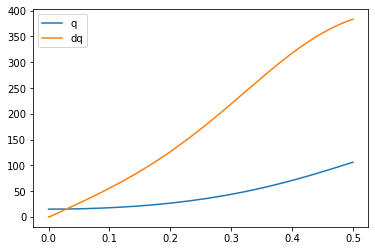

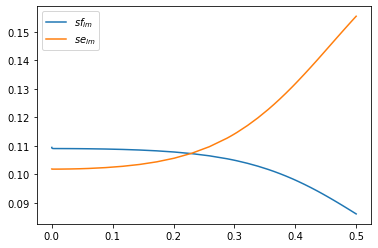

In [20]:
plot(tt, rad2deg(states[0, :]), label='q')
plot(tt, rad2deg(states[1, :]), label="dq")
legend()

figure()
plot(tt, states[2, :], label="$sf_{lm}$")
plot(tt, states[3, :], label="$se_{lm}$")

legend()